In [1]:
import os
import os.path as op
import pandas as pd
import numpy as np
import re
import json
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
%run "../config.py" # this imports variables from config.py as global

split_data = False
data_filepath = '/home/veera/LST_project/data/Merged_Label_Set.csv'
out_fpath = op.join(op.dirname(data_filepath), 'full_training_data.csv')

In [2]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [3]:
text_column_name = 'text'
column_names = ['id_str', text_column_name, 'label']
stop_words = set(stopwords.words('english'))
ngram_range = (1, 2)
min_df = 3 # cut-off value for ignoring rare words
max_df = 1.0
max_features = 500
vectorizer = CountVectorizer(encoding='utf-8',
                             ngram_range=ngram_range,
                             stop_words=stop_words,
                             max_df=max_df,
                             min_df=min_df,
                             max_features=max_features)

In [4]:
# Load data
def load_from_file(filepath):
    if filepath.endswith('.json'):
        data_arr = []
        with open(filepath, 'r') as f:
            for tweet in f:
                selected_row = []
                json_tweet = json.loads(tweet)
                try:
                    if json_tweet['truncated']:
                        text = json_tweet['extended_tweet']['full_text']
                    else:
                        text = json_tweet['full_text']
                except KeyError:
                        text = json_tweet['text']
                try:
                    # filter out retweets and non-English tweets
                    #print(not json_tweet['retweeted'] and 'RT @' not in text and json_tweet['lang'] == 'en')
                    if not json_tweet['retweeted'] and 'RT @' not in text and json_tweet['lang'] == 'en':
                        data_arr.append([json_tweet['id_str'], text])
                except KeyError:
                    pass
            data = pd.DataFrame(data_arr, columns=column_names)
    elif filepath.endswith('.csv'):
        data = pd.read_csv(filepath)[column_names]
    else:
        data = None
    return data

In [5]:
data = load_from_file(data_filepath)
print(data.shape)
print(data.head(10))
tweets = data[text_column_name]

(1040, 3)
                                              id_str  \
0  b'Z0FBQUFBQmVoeE4zMFJ3QmNnek4zWWlzamFOeXY2NXl6...   
1  b'Z0FBQUFBQmVoeE4zXzFKZjhPQ1NXTHJMV1JPd0QxRUo0...   
2  b'Z0FBQUFBQmVoeE4zbjNqTUlFNHIwN3Zpb2hqOWV1S3Fh...   
3  b'Z0FBQUFBQmVoeE4zcmx1YU9jYWdFRjh2Z254SE0xUm5I...   
4  b'Z0FBQUFBQmVoeE4zLWlwdmF6eEVVVGMzOE0zR3dtUUYt...   
5  b'Z0FBQUFBQmVoeE4zUE9YLV91blFVbGNDWE0zWE5OMng0...   
6  b'Z0FBQUFBQmVoeE4zYkhLUnJjLWNNaVNUNERXb1JJTld4...   
7  b'Z0FBQUFBQmVoeE4zTHp5dlBrZkhqLVE4a1g0LU9Kdlh5...   
8  b'Z0FBQUFBQmVoeE4zLURfOXd6aVBrUFgtSVlYUXpVZG9u...   
9  b'Z0FBQUFBQmVoeE4zellqOUlZU3dkQnZZRm93ODFEQkxV...   

                                                text  label  
0  @ASavageNation Personal empowerment, incorpora...      4  
1  Enjoying to read "radical ideas for saving nat...      1  
2  Although she mostly appears to be calm, she al...      4  
3  @justioify I assure you these celebs are payin...      4  
4  @WyomingScience @SethKlamann @LaurelMildred Yo...      4  
5

In [6]:
def preprocess(item):
    item = item.lower() # convert to lowercase
    item = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in item.split()]) # lemmatizing
    item = item.replace('-', ' ') # replace dashes with whitespace
    # remove numbers, punctuation, tags and URLs
    item = re.sub(r'[^a-zA-Z ]+|(@[A-Za-z0-9]+)|http\S+', '', item)
    return item

In [7]:
# get the distribution of top unigrams
def get_top_n_words(corpus, vectorizer, n=None):
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

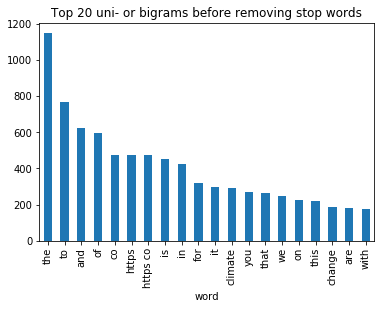

In [8]:
common_words_original = get_top_n_words(tweets, CountVectorizer(ngram_range=(1, 2)), 20)
df1 = pd.DataFrame(common_words_original, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot.bar(
    x='word', y='count', title='Top 20 uni- or bigrams before removing stop words')

In [9]:
preprocessed_tweets = tweets.apply(preprocess)
preprocessed_tweets.head(10)

0    asavagenation personal empowerment incorporate...
1    enjoy to read radical idea for save nature by ...
2    although she mostly appear to be calm she also...
3    justioify i assure you these celebs be pay the...
4    wyomingscience sethklamann laurelmildred your ...
5          all the more reason to get rid of the idiot
6     tradegovuk high potential opportunity   dorse...
7    that feel when eden  be still going but youre ...
8    collaboration the movement be collaborative by...
9    denisebatters but hes prepared for year on thi...
Name: text, dtype: object

In [10]:
vec = vectorizer.fit(preprocessed_tweets)

In [11]:
X = vec.transform(preprocessed_tweets).toarray()
# Add other columns
X = np.c_[data['id_str'], X, data['label']]
vec.get_feature_names()

['across',
 'act',
 'action',
 'actually',
 'address',
 'agenda',
 'ago',
 'agree',
 'agreenergoogle',
 'air',
 'air pollution',
 'already',
 'also',
 'always',
 'america',
 'american',
 'amp',
 'animal',
 'announce',
 'anyone',
 'anything',
 'appreciate',
 'apr',
 'apr climate',
 'april',
 'area',
 'around',
 'article',
 'ask',
 'atmosphere',
 'attention',
 'away',
 'back',
 'bad',
 'bag',
 'barackobama',
 'base',
 'beautiful',
 'become',
 'begin',
 'believe',
 'bernie',
 'best',
 'biden',
 'big',
 'billion',
 'bin',
 'biodiversity',
 'bit',
 'blue',
 'box',
 'building',
 'business',
 'call',
 'cant',
 'car',
 'carbon',
 'carbon footprint',
 'care',
 'case',
 'cause',
 'challenge',
 'change',
 'change denial',
 'check',
 'child',
 'china',
 'city',
 'claim',
 'clean',
 'clear',
 'climate',
 'climate action',
 'climate change',
 'climate crisis',
 'climate hi',
 'climatechange',
 'climatecrisis',
 'close',
 'co',
 'coal',
 'come',
 'community',
 'company',
 'consequence',
 'consider',


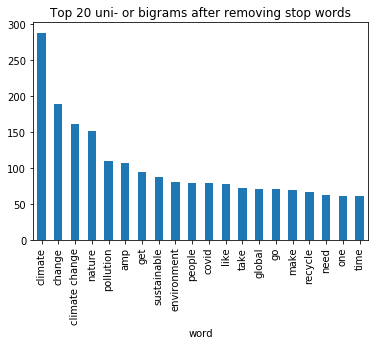

In [12]:
common_words_preprocessed = get_top_n_words(preprocessed_tweets, 
                                            CountVectorizer(ngram_range=(1, 2), stop_words=stop_words), 
                                            20)
df1 = pd.DataFrame(common_words_preprocessed, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot.bar(
    x='word', y='count', title='Top 20 uni- or bigrams after removing stop words')

In [13]:
if split_data:
    # Split the matrix into random training and testing subsets
    test_size = 0.25
    train_fpath = op.join(op.dirname(data_filepath), 'train_data.csv')
    test_fpath = op.join(op.dirname(data_filepath), 'test_data.csv')

    X_train, X_test = train_test_split(X, test_size=test_size)
    # "Label" instead of "label" to make sure it's a unique column name
    X_train = pd.DataFrame(X_train, columns=['id_str']+vectorizer.get_feature_names()+['Label'])
    X_test = pd.DataFrame(X_test, columns=['id_str']+vectorizer.get_feature_names()+['Label'])
    print(X_train.shape, X_test.shape)
    print(X_train.head())
    # Save to csv files
    X_train.to_csv(train_fpath, index=False)
    X_test.to_csv(test_fpath, index=False)
else:
    X = pd.DataFrame(X, columns=['id_str']+vectorizer.get_feature_names()+['Label'])
    print(X.shape)
    print(X.head())
    X.to_csv(out_fpath, index=False)

(1040, 502)
                                              id_str across act action  \
0  b'Z0FBQUFBQmVoeE4zMFJ3QmNnek4zWWlzamFOeXY2NXl6...      0   0      0   
1  b'Z0FBQUFBQmVoeE4zXzFKZjhPQ1NXTHJMV1JPd0QxRUo0...      0   0      0   
2  b'Z0FBQUFBQmVoeE4zbjNqTUlFNHIwN3Zpb2hqOWV1S3Fh...      0   0      0   
3  b'Z0FBQUFBQmVoeE4zcmx1YU9jYWdFRjh2Z254SE0xUm5I...      0   0      0   
4  b'Z0FBQUFBQmVoeE4zLWlwdmF6eEVVVGMzOE0zR3dtUUYt...      0   0      0   

  actually address agenda ago agree agreenergoogle  ... would wrong yeah year  \
0        0       0      0   0     0              0  ...     0     0    0    0   
1        0       0      0   0     0              0  ...     0     0    0    0   
2        0       0      0   0     0              0  ...     0     0    0    0   
3        0       0      0   0     0              0  ...     0     0    0    0   
4        0       0      0   0     0              0  ...     0     0    0    0   

  year ago years yet young youre Label  
0        0     

In [15]:
# Vectorize other sets of tweets using the fitted vectorizer
input_filepath = '/home/veera/LST_project/data/chicago/'
outfile = op.join(op.dirname(input_filepath), 'full_data.csv')
column_names = ['id_str', 'full_text']
if op.isdir(input_filepath):
    # Collect data from all .json or .csv files in the directory
    dfs = []
    for f in os.listdir(input_filepath):
        if f.endswith('.json'):
            path = op.join(op.dirname(input_filepath), f)
            df = load_from_file(path)
            dfs.append(df)
    input_data = pd.concat(dfs)
elif op.isfile(input_filepath):
    input_data = load_from_file(input_filepath)
tweets_2 = input_data['full_text']
preprocessed_tweets_2 = tweets_2.apply(preprocess)
X_2 = vec.transform(preprocessed_tweets_2).toarray()
# Add other columns
X_2 = np.c_[input_data['id_str'], X_2]
X_2 = pd.DataFrame(X_2, columns=['id_str']+vectorizer.get_feature_names())
print(X_2.shape)
print(X_2.head())
X_2.to_csv(outfile, index=False)

(17706, 501)
                id_str across act action actually address agenda ago agree  \
0  1245275305331343362      0   0      0        0       0      0   0     0   
1  1245276936336785408      0   0      0        0       0      0   0     0   
2  1245278364014989313      0   0      0        0       0      0   0     0   
3  1245280165271404549      0   0      0        0       0      0   0     0   
4  1245280185592799232      0   0      0        0       0      0   0     0   

  agreenergoogle  ... worried would wrong yeah year year ago years yet young  \
0              0  ...       0     0     0    0    0        0     0   0     0   
1              0  ...       0     0     0    0    0        0     0   0     0   
2              0  ...       0     0     0    0    0        0     0   0     0   
3              0  ...       0     0     0    0    0        0     0   0     0   
4              0  ...       0     0     0    0    1        0     0   0     0   

  youre  
0     0  
1     0  
2     0